![msg](msg.jpg)

In [52]:
#Imports 
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns 

from tqdm import tqdm

from DiscEvolution.grid import Grid
from DiscEvolution.star import SimpleStar
#from DiscEvolution.eos import LocallyIsothermalEOS  
from DiscEvolution.eos import SimpleDiscEOS
#from DiscEvolution.disc import AccretionDisc
from DiscEvolution.viscous_evolution import ViscousEvolutionFV
from DiscEvolution.driver import PlanetDiscDriver
from DiscEvolution.io import Event_Controller
from DiscEvolution.dust import DustGrowthTwoPop, SingleFluidDrift


In [53]:
# Physical parameters
#Assumed
Mstar = 1.0 * u.solMass #Default 1 solmass 
Rstar = 1.0 * u.solRad #Default 1 solRad
mu = 2.33  # Mean molecular weight, assumed

#Given
M_disk_0 = 0.05 * u.solMass  #Initial Disk Mass, default is 0.05 solmass
gamma = 1.0
Rc = 1.0 * u.AU #Default 1AU
#Mdot_0 = 
t_final = 1 * u.Myr 

# LBP surface density profile with gamma = 1: Sigma(r) = (M_disk / (2*pi*Rc*r)) * exp(-r/Rc)
def Sigma_LBP_1(r) -> float:
    val = (M_disk_0)/(2* np.pi * Rc * r) * np.exp((-1*r)/(Rc))
    if (val.cgs.unit != (u.g / (u.cm)**2)):
        print("Sigma_1 error")
        return 0
    return val.cgs

def Temperature(r) -> float:
    T_0 = 150 * u.K 
    val  = T_0 * (r / (1.0 * u.AU))**(-1/2)
    if val.cgs.unit != u.K:
        print('Temperature error')
        return 0
    return val.cgs

#Taken from A2
def Omega(r) -> float:
    val = np.sqrt((const.G*Mstar)/(r**3))
    if (val.cgs.unit != (1 / u.s)): 
        print("Omega error")
        return 0
    return val.cgs

#Taken from A2
def c_s(r) -> float:
    val = np.sqrt((const.k_B*Temperature(r))/(mu*const.m_p))
    if (val.cgs.unit != (u.cm / u.s)): 
        print("c_s error")
        return 0
    return val.cgs

def H(r) -> float: 
    val = c_s(r)/Omega(r)
    if val.cgs.unit != (u.cm):
        print("H error")
        return 0
    return val.cgs

In [54]:
#Given Mdisk, Mdot(0), Rc -> Calculate alpha and Sigma0
M_disk_0 = 0.01 * u.solMass
Mdot_0 = 1E-7 * u.solMass / u.yr  #Armitage p.21
Rc = 100.0 * u.AU

#Armitage eq 74
#nu*Sigma = Mdot/(3pi) * (1 - sqrt(r_star/r))
##alpha * c_s * H * Sigma = (Mdot / 3*pi) * (1 - sqrt(r_star/r))
###alpha = (Mdot / 3*pi) / (c_s * H * Sigma) * (1 - sqrt(r_star/r))

def alpha(r) -> float:
    # Convert all inputs to CGS values (no units)
    Mdot_cgs = Mdot_0.to(u.g / u.s).value  # g/s
    cs_val = c_s(r).value                   # cm/s
    H_val = H(r).value                      # cm
    Sigma_val = Sigma_LBP_1(r).value       # g/cm²
    Rstar_val = Rstar.to(u.cm).value       # cm
    r_val = r.to(u.cm).value               # cm
    
    # Calculate dimensionless alpha
    alpha = (Mdot_cgs / (3*np.pi)) * (1/(cs_val * H_val * Sigma_val)) * (1 - np.sqrt(Rstar_val/r_val))
    
    return alpha  # Pure float, dimensionless

r_ref = Rc #Not Rstar
alpha_val = alpha(r_ref)

Sigma_0 = Sigma_LBP_1(r_ref)

print(f"Accretion rate: {Mdot_0:.3e}")
print(f"At radius: {r_ref.to(u.AU):.3f}")
print(f"\nCalculated alpha: {alpha_val:.3e}")
print(f"Sigma_0: {Sigma_0.cgs:.3e}")


Accretion rate: 1.000e-07 solMass / yr
At radius: 100.000 AU

Calculated alpha: 4.782e-01
Sigma_0: 5.202e-01 g / cm2


In [55]:
# 1) Create grid
#R_in = Rstar.to('AU').value  # AU
R_in = 0.1 #AU
R_out = 1000.0  # AU
Ncells = 500

grid = Grid(R_in, R_out, Ncells, spacing='natural')

# 2) Create star
star = SimpleStar(M=1.0,R = 2.5, T_eff = 4000.0)  # Already in solar masses and radii

In [56]:
#1. turbulence dominated disk with fixed LBP T profile 

# 3) Create EOS - h0 is H/R at 1 AU (dimensionless aspect ratio ~0.03-0.05)
h0_at_1AU = H(Rc).to(u.AU).value / Rc.to(u.AU).value  # H/R, dimensionless
print(f"h0 (H/R at 1 AU): {h0_at_1AU:.4f}")

# q parameter: for T ∝ r^(-1/2), we have cs ∝ T^(1/2) ∝ r^(-1/4), so q = -0.25
eos = SimpleDiscEOS(star, alpha_t=1e-3, K0 = 0.01)
eos.set_grid(grid)

# 4) Create surface density array from LBP profile
R_centers = grid.Rc  # AU
Sigma_initial = np.array([Sigma_LBP_1(r * u.AU).value for r in R_centers])
eos.update(0, Sigma_initial)

# 5) Create the disc with dust
# eps = initial dust-to-gas ratio (dust fraction)
disc = DustGrowthTwoPop(
    grid, star, eos, 
    eps=0.01,              # Initial dust-to-gas ratio (1%)
    Sigma=Sigma_initial,
    feedback=True,         # Dust affects gas dynamics
    f_ice=1.0,             # Ice fraction (affects fragmentation)
    uf_0=1000,             # Fragmentation velocity for dry grains (cm/s)
    uf_ice=1000,           # Fragmentation velocity for icy grains (cm/s)
    thresh=0.5             # Threshold for ice effects
)

disc._planetesimal = False

drift = SingleFluidDrift(diffusion=None, settling=True)

# DO NOT OVERRIDE EOS ARRAYS - let it use its own consistent units
# Just verify the setup
print(f"\nDisc setup:")
print(f"  Grid: {disc.Ncells} cells from {R_in} to {R_out} AU")
print(f"  Disc mass: {disc.Mtot()/const.M_sun.to(u.g).value:.3e} solar masses")
print(f"  Alpha: {alpha_val:.3e}")

# Check temperature at 1 AU
idx_1AU = np.argmin(np.abs(disc.R - 1.0))
print(f"\nAt 1 AU (from EOS):")
print(f"  T: {disc.T[idx_1AU]:.1f} K")
print(f"  cs (code units): {disc.cs[idx_1AU]:.4f}")
print(f"  H (code units): {disc.H[idx_1AU]:.4f} AU")
print(f"  nu (code units): {disc.nu[idx_1AU]:.4e}")

h0 (H/R at 1 AU): 0.0774

Disc setup:
  Grid: 500 cells from 0.1 to 1000.0 AU
  Disc mass: 9.990e-03 solar masses
  Alpha: 4.782e-01

At 1 AU (from EOS):
  T: 177.8 K
  cs (code units): 0.0267
  H (code units): 0.0247 AU
  nu (code units): 6.6026e-07


In [57]:
# Evolution with correct time units
# DiscEvolution uses code units: 1 year = 2π code time units

from DiscEvolution.constants import yr as yr_code  # yr_code = 2π


from DiscEvolution.internal_photo import ConstantInternalPhotoevap
int_photo = ConstantInternalPhotoevap(1e-9)   # Msun / yr


# Set up evolution
visc_evol = ViscousEvolutionFV(tol=0.5, boundary='power_law', in_bound='Mdot')
driver = PlanetDiscDriver(disc, gas=visc_evol, dust=drift, int_photoevaporation=int_photo, t0=0.0)
# Time in code units
t_final_yr = t_final.to(u.yr).value  # 1e6 years
t_final_code = t_final_yr * yr_code  # Convert to code units

# Check timestep
dt_max = visc_evol.max_timestep(disc)
dt_max_yr = dt_max / yr_code
print(f"=== EVOLUTION SETUP ===")
print(f"t_final: {t_final_yr:.0e} years = {t_final_code:.2e} code units")
print(f"dt_max: {dt_max:.2e} code units = {dt_max_yr:.1f} years")
print(f"Estimated steps: {t_final_code/dt_max:.1e}")

# Output times (in code units)
output_times_yr = np.linspace(0, t_final_yr, 11)  # Every 100 kyr
output_times_code = output_times_yr * yr_code
io = Event_Controller(save=output_times_code)

history = {'t_yr': [], 'Mtot': [], 'Rout': [], 'dt_yr': []}
#snapshot_times = np.linspace(0, t_final_yr, 4)  # Every ~300 kyr
snapshot_times = np.array([0., 1e5, 5e5, 1e6])
snapshots = {'t_yr': [], 'Sigma_G': [], 'Sigma_D': [], 'dust_frac': [], 'St': [], 'grain_size': [], 'T': []}

print(f"\nStarting evolution...")
pbar = tqdm(total=t_final_yr, unit='yr', desc='Evolution')
last_t_yr = 0.0
step_count = 0
snapshot_idx = 0

while not io.finished():
    ti = io.next_event_time()
    
    while driver.t < ti:
        dt = driver(ti)
        step_count += 1
        
        # Update progress
        t_yr = driver.t / yr_code
        pbar.update(t_yr - last_t_yr)
        last_t_yr = t_yr
        
        # Diagnostic every 1000 steps
        if step_count % 2000 == 0:
            dt_yr = dt / yr_code
            #print(f"\nStep {step_count}: t = {t_yr:.2e} yr, dt = {dt_yr:.1f} yr")

        while snapshot_idx < len(snapshot_times)  and t_yr >= snapshot_times[snapshot_idx]:
            # Store snapshots in memory for later plotting
            snapshots['t_yr'].append(t_yr)
            snapshots['Sigma_G'].append(disc.Sigma_G.copy())
            snapshots['Sigma_D'].append(disc.Sigma_D.sum(axis=0).copy()) #Total dust Sigma, pebbles + grains
            snapshots['dust_frac'].append(disc.dust_frac.sum(axis=0).copy()) #Total dust to gas ratio
            snapshots['St'].append(disc.Stokes()[1].copy())  #Pebbles not small grains
            snapshots['grain_size'].append(disc.grain_size[1].copy()) #Pebbles not small grains
            snapshots['T'].append(disc.T.copy()) #Temp

            snapshot_idx += 1


    # Store at output times
    if io.check_event(driver.t, 'save'):
        dt_current = visc_evol.max_timestep(disc)
        history['t_yr'].append(driver.t / yr_code)
        history['Mtot'].append(disc.Mtot() * u.g.to(u.solMass))
        history['Rout'].append(disc.Rout())
        history['dt_yr'].append(dt_current / yr_code)
        io.pop_events(driver.t, 'save')

pbar.close()

print(f"\n=== EVOLUTION COMPLETE ===")
print(f"Total steps: {step_count}")
print(f"Final time: {driver.t/yr_code:.1e} years")
print(f"Final mass: {history['Mtot'][-1]:.3e} M_sun ({100*history['Mtot'][-1]/history['Mtot'][0]:.1f}% of initial)")
print(f"Average dt: {np.mean(history['dt_yr']):.1f} years")

=== EVOLUTION SETUP ===
t_final: 1e+06 years = 6.28e+06 code units
dt_max: 2.25e+02 code units = 35.9 years
Estimated steps: 2.8e+04

Starting evolution...


Evolution: 100%|██████████| 1000000.0/1000000.0 [00:05<00:00, 171959.97yr/s]         


=== EVOLUTION COMPLETE ===
Total steps: 10830
Final time: 1.0e+06 years
Final mass: 8.378e-03 M_sun (83.9% of initial)
Average dt: 92.1 years


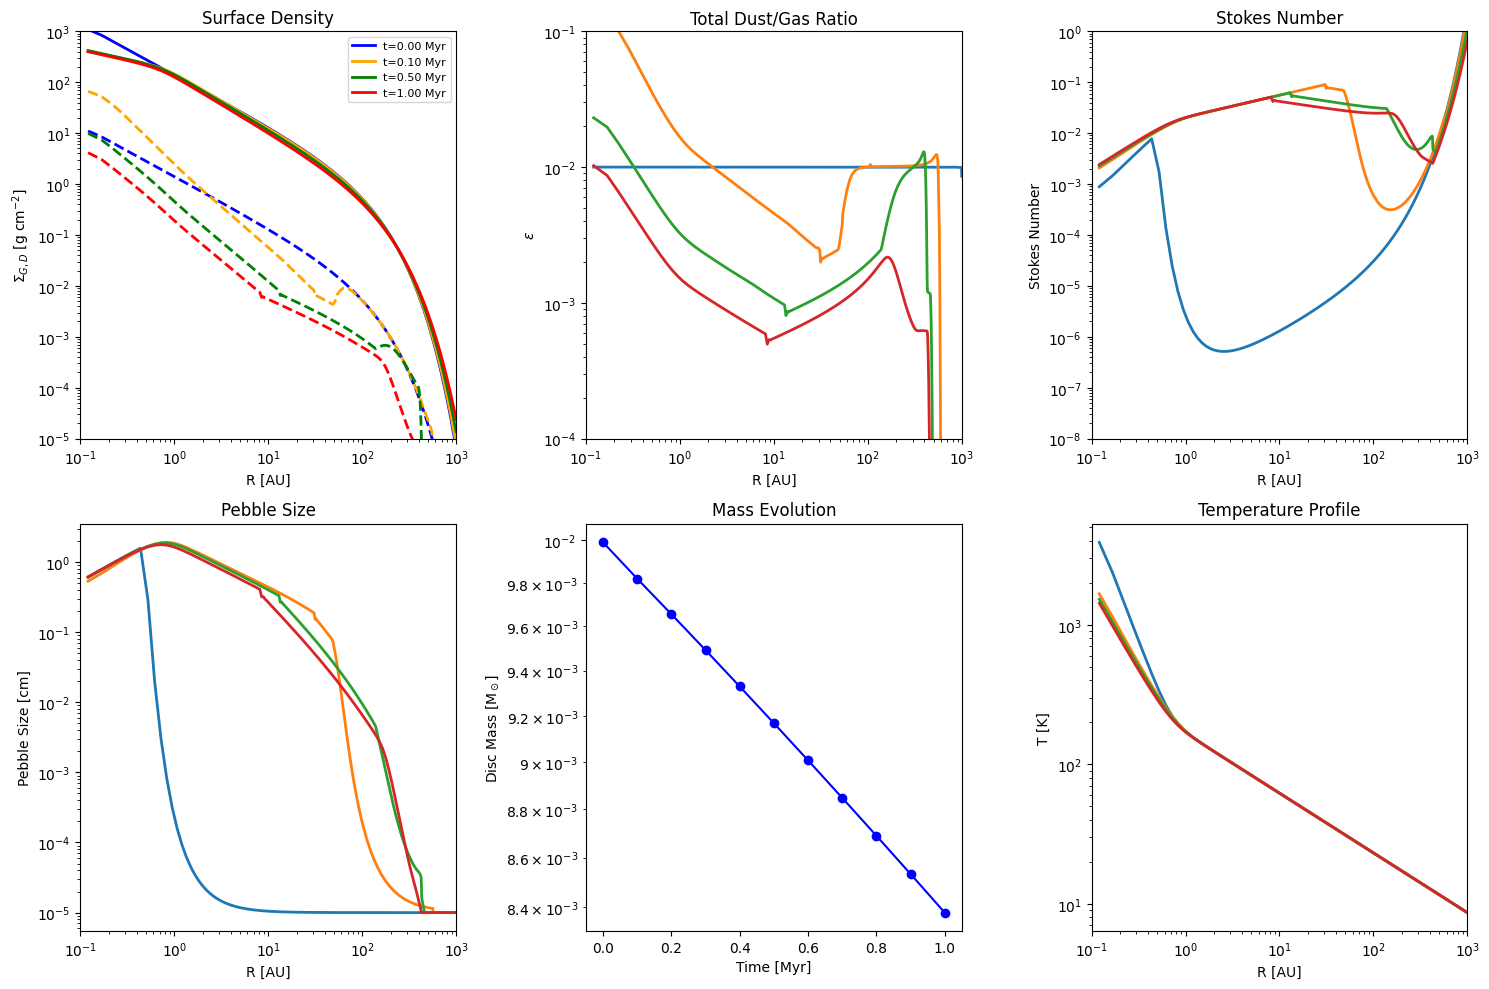


=== Summary ===
Initial mass: 9.990e-03 M_sun
Final mass:   8.378e-03 M_sun (83.9% remaining)
Final dust/gas at 10 AU: 0.0005
Max pebble size: 1.77 cm at R = 0.7 AU


In [58]:
# Plot evolution results with dust properties
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Surface density: Gas and Dust
ax = axes[0, 0]
#ax.loglog(disc.R, Sigma_initial, 'k--', label='Initial Total', alpha=0.5)
#ax.loglog(disc.R, disc.Sigma_G, 'k-', label='Gas', lw=2)
#ax.loglog(disc.R, disc.Sigma_D.sum(axis=0), 'k--', label='Dust (Total)', lw=2)
#ax.loglog(disc.R, disc.Sigma_D[0], 'g--', label='Small Dust')
#ax.loglog(disc.R, disc.Sigma_D[1], 'r:', label='Pebbles', lw=2)

from cycler import cycler
c = ['blue','orange','g','r']
ax.set_prop_cycle(cycler(color=c))

i = 0
for line in snapshots['Sigma_G']:
    ax.loglog(disc.R, line, linestyle = 'solid', label=rf"t={snapshots['t_yr'][i]/1e6:.2f} Myr", lw=2)
    i += 1

i = 0
for line in snapshots['Sigma_D']:
    ax.loglog(disc.R, line, linestyle = 'dashed', lw=2)
    i += 1
ax.set_ylim(1e-5, 1e3)
ax.set_xlabel('R [AU]')
ax.set_ylabel(r'$\Sigma_{G,D}$ [g cm$^{-2}$]')
ax.set_title('Surface Density')
ax.legend(fontsize=8)
ax.set_xlim(R_in, R_out)

# 2. Dust-to-gas ratio (epsilon)
ax = axes[0, 1]
#ax.loglog(disc.R, disc.dust_frac[0], 'g--', label='Small grains')
#ax.loglog(disc.R, disc.dust_frac[1], 'r-', label='Pebbles', lw=2)
#ax.loglog(disc.R, disc.dust_frac.sum(0), 'k-', label='Total', lw=2)
#ax.axhline(0.01, ls=':', color='gray', alpha=0.5, label='Initial (1%)')

i = 0
for line in snapshots['dust_frac']:
    ax.loglog(disc.R, line, linestyle = 'solid', label=rf"t={snapshots['t_yr'][i]/1e6:.2f} Myr", lw=2)
    i += 1

ax.set_xlabel('R [AU]')
ax.set_ylabel(r'$\epsilon$')
ax.set_title('Total Dust/Gas Ratio')
#ax.legend(fontsize=8)
ax.set_xlim(R_in, R_out)
ax.set_ylim(1e-4,1e-1)

# 3. Stokes number (Stokes() is a method, returns [small, large] array)
ax = axes[0, 2]
#St = disc.Stokes()  # Call the method
#ax.loglog(disc.R, St[0], 'g--', label='Small grains')
#ax.loglog(disc.R, St[1], 'r-', label='Pebbles', lw=2)
#ax.axhline(1.0, ls=':', color='gray', alpha=0.5, label='St = 1')

i = 0
for line in snapshots['St']:
    ax.loglog(disc.R, line, linestyle = 'solid', label=rf"t={snapshots['t_yr'][i]/1e6:.2f} Myr", lw=2)
    i += 1

ax.set_xlabel('R [AU]')
ax.set_ylabel('Stokes Number')
ax.set_title('Stokes Number')
#ax.legend(fontsize=9)
ax.set_xlim(R_in, R_out)
ax.set_ylim(1e-8,1e0)

# 4. Pebble size
ax = axes[1, 0]
#ax.loglog(disc.R, disc.grain_size[0], 'g--', label='Small grains')
#ax.loglog(disc.R, disc.grain_size[1], 'r-', label='Pebbles', lw=2)

i = 0
for line in snapshots['grain_size']:
    ax.loglog(disc.R, line, linestyle = 'solid', label=rf"t={snapshots['t_yr'][i]/1e6:.2f} Myr", lw=2)
    i += 1


ax.set_xlabel('R [AU]')
ax.set_ylabel('Pebble Size [cm]')
ax.set_title('Pebble Size')
#ax.legend(fontsize=9)
ax.set_xlim(R_in, R_out)

# 5. Mass evolution
ax = axes[1, 1]
ax.semilogy(np.array(history['t_yr'])/1e6, np.array(history['Mtot']), 'o-', color='blue')
ax.set_xlabel('Time [Myr]') 
ax.set_ylabel(r'Disc Mass [M$_\odot$]')
ax.set_title('Mass Evolution')

# 6. Temperature profile
ax = axes[1, 2]
#ax.loglog(disc.R, disc.T, 'r-', lw=2)

i = 0
for line in snapshots['T']:
    ax.loglog(disc.R, line, linestyle = 'solid', label=rf"t={snapshots['t_yr'][i]/1e6:.2f} Myr", lw=2)
    i += 1

ax.set_xlabel('R [AU]')
ax.set_ylabel('T [K]')
ax.set_title('Temperature Profile')
ax.set_xlim(R_in, R_out)

plt.tight_layout()
#plt.savefig('Jan2026-LBP-dust_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n=== Summary ===")
print(f"Initial mass: {history['Mtot'][0]:.3e} M_sun")
print(f"Final mass:   {history['Mtot'][-1]:.3e} M_sun ({100*history['Mtot'][-1]/history['Mtot'][0]:.1f}% remaining)")
print(f"Final dust/gas at 10 AU: {disc.dust_frac.sum(0)[np.argmin(np.abs(disc.R-10))]:.4f}")
print(f"Max pebble size: {disc.grain_size[1].max():.2f} cm at R = {disc.R[np.argmax(disc.grain_size[1])]:.1f} AU")